In [3]:
import numpy as np
import pandas as pd
import pydicom
import glob
import os
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow.keras 
from skimage.transform import resize
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.initializers import glorot_uniform

In [6]:
# This function reads in a .dcm file, checks the important fields for our device, and returns a numpy array
# of just the imaging data
def check_dicom(filename): 
    print('Load file {} ...'.format(filename))
    ds = pydicom.dcmread(filename)
    if (ds.Modality == 'DX') and (ds.BodyPartExamined=='CHEST') and (ds.PatientPosition in ['PA','AP']):
        img = ds.pixel_array
        return img
    else:
        print('This file does not match criteria of being a Chest X-Ray in PA or AP viewing position\n')
    
    
# This function takes the numpy array output by check_dicom and 
# runs the appropriate pre-processing needed for our model input
def preprocess_image(img,img_mean,img_std,img_size): 
    proc_img = ((img/255)-img_mean)/img_std
    proc_img = resize(proc_img, img_size)
    return proc_img

# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path):
    with open(model_path, 'r') as json_file:
        json_savedModel= json_file.read() 
        
    model = model_from_json(json_savedModel)
    model.load_weights(weight_path)
    
    return model

# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh): 
    pred = model.predict(img)
    if pred>thresh:
        prediction = 'Pneumonia Positive'
    else:
        prediction = 'Pneumonia Negative'
    
    return prediction 

Load file data\test\test1.dcm ...


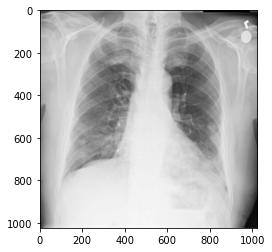

Prediction: Pneumonia Positive || Study Label: No Finding


Load file data\test\test2.dcm ...


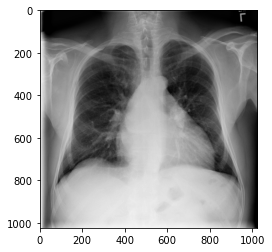

Prediction: Pneumonia Positive || Study Label: Cardiomegaly


Load file data\test\test3.dcm ...


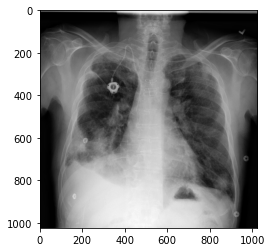

Prediction: Pneumonia Positive || Study Label: Effusion


Load file data\test\test4.dcm ...
This file does not match criteria of being a Chest X-Ray in PA or AP viewing position

Load file data\test\test5.dcm ...
This file does not match criteria of being a Chest X-Ray in PA or AP viewing position

Load file data\test\test6.dcm ...
This file does not match criteria of being a Chest X-Ray in PA or AP viewing position



In [7]:
test_dicoms = glob.glob(os.path.join('data','test','*.dcm'))

model_path = 'out/my_model1.json'
weight_path = 'out/xray_class_my_model.best.hdf5'

IMG_SIZE=(1,224,224,3) # This might be different if you did not use vgg16
img_mean = 0 # loads the mean image value they used during training preprocessing.  Normalized with ImageDataGenerator
img_std = 1 # loads the std dev image value they used during training preprocessing.  Normalized with ImageDataGenerator

my_model = load_model(model_path, weight_path)
thresh = 0.24509374797344208 #loads the threshold they chose for model classification 

# use the .dcm files to test your prediction
for i in test_dicoms:
    
    img = np.array([])
    img = check_dicom(i)
    
    if img is None:
        continue
        
    img_proc = preprocess_image(img,img_mean,img_std,IMG_SIZE)
    pred = predict_image(my_model,img_proc,thresh)
    plt.imshow(img, cmap='gray')
    plt.show()
    print(f'Prediction: {pred} || Study Label: {pydicom.dcmread(i).StudyDescription}\n\n')
    

In [8]:
my_dicom=pydicom.dcmread(test_dicoms[3])
my_dicom

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 204
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.11129.5.5.110503645592756492463169821050252582267888
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.8.498.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 1.2.0'
-------------------------------------------------
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.110503645592756492463169821050252582267888
(0008, 0060) Modality                            CS: 'DX'
(0008, 1030) Study Description                   LO: 'No Finding'
(0010, 0020) Patien